In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import make_circles
from scipy.special import expit
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report

In [110]:
# Define a seed.
seed = 42

# Number of examples.
N = 1000

# Create a 2-class dataset for classification.
centers = [[-5.0, 0], [0, 5.0]]

x, y = make_blobs(n_samples=N, centers=centers, random_state=seed)

Y = y

y = y/1.0;

y = y.reshape(len(y), 1)

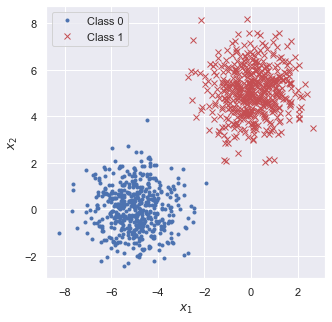

In [111]:
idx0 = np.argwhere(Y == 0)
idx1 = np.argwhere(Y == 1)

fig = plt.figure(figsize=(5,5))
plt.plot(x[idx0,0], x[idx0,1], '.', label='Class 0')
plt.plot(x[idx1,0], x[idx1,1], 'rx', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [112]:
def error_function(x, a, y):
    error = 0.0
    for i in range(0, len(y)):
        h = np.heaviside(x[i,:].dot(a), 1.0)
        error += np.power(y[i] - h, 2.0)
    return error/len(y)

def classifier(x, a):
    h = np.heaviside(x.dot(a), 1.0)
    c = np.zeros((len(h), 1))
    for i in range(0, len(h)):
        if(h[i] >= 0.5):
            c[i,0]=1.0
    return c

def predict_prob(x, a):
    h1 = np.heaviside(x.dot(a), 1.0)
    h0 = 1 - h1
    h = np.c_[h0, h1]
    return h

def classificationWithRigidThreshold(x_train, y_train, x_test, y_test, alpha, numEpochs):
    # Random initialization of parameters.
    a = np.random.randn(x_train.shape[1], 1)

    # Create array for storing error values.
    Jgd = np.zeros(numEpochs*len(y_train)+1)
    Jgd_v = np.zeros(numEpochs*len(y_train)+1)

    # Calculate initial error.
    Jgd[0] = error_function(x_train, a, y_train)
    Jgd_v[0] = error_function(x_test, a, y_test)

    # Batch gradient-descent loop.
    minimum_val_error = float("inf")
    iteration = 0
    epoch = 0
    error = float("inf")
    M = len(y_train)
    while epoch < numEpochs:

        for idx in range(0, M):
            # Draw a random pair of training samples.
            rndidx = np.random.randint(M)
            x = x_train[rndidx,:].reshape(1, 3)
            y = y_train[rndidx].reshape(1, 1)

            # Update weights.
            gradients = x.T.dot(y - np.heaviside(x.dot(a), 1.0))
            a = a + alpha * gradients

            # Calculating training and validation errors.
            Jgd[iteration+1] = error_function(x_train, a, y_train)
            Jgd_v[iteration+1] = error_function(x_test, a, y_test)

            # Calculate error for stopping criteria.
            error = np.abs(Jgd[iteration+1] - Jgd[iteration])

            # Store weights for the smallest error ever.
            if(Jgd_v[iteration+1] < minimum_val_error):
                minimum_val_error = Jgd_v[iteration+1]
                a_min = a

            iteration += 1

        epoch += 1
    return Jgd, Jgd_v, iteration, a_min, minimum_val_error

In [113]:
# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [114]:
# Learning rate.
alpha = 0.1
# Maximum number of iterations.
numEpochs = 2

Jgd, Jgd_v, iteration, a_min, minimum_val_error = classificationWithRigidThreshold(x_train, y_train, x_test, y_test, alpha, numEpochs)

print('minimum_val_error', minimum_val_error)

minimum_val_error 0.0


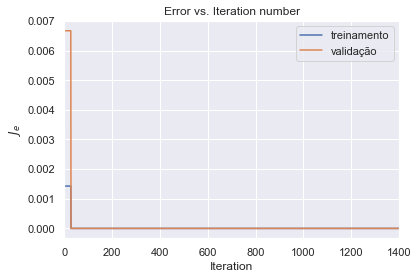

In [115]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

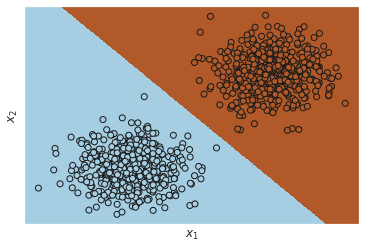

In [116]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = classifier(np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()], a_min)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

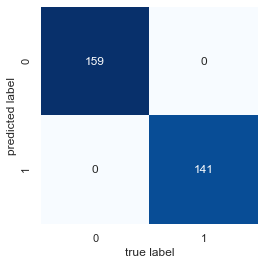

In [117]:
y_pred_class = classifier(x_test, a_min)

# Plot the confusion matrix
mat = confusion_matrix(y_test, y_pred_class)
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1'], yticklabels=['0','1'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

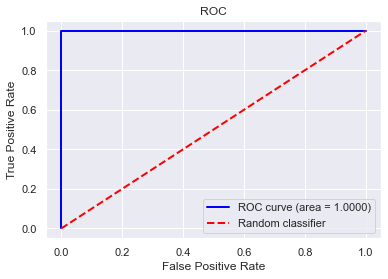

In [118]:
# Getting the probabilities for each class.
y_prob = predict_prob(x_test, a_min)
# Calculating ROC curve and ROC AUC.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
# Plotting ROC curve.
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=lw, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [119]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       159
         1.0       1.00      1.00      1.00       141

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

